# Trabajo Práctico 1: Árboles de Decisión

Primero que nada, importamos las librerías que vamos a utilizar.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn import tree
import numpy as np
import pandas as pd


## Ejercicio 1

A continuación se incluye el código para la generación de las espirales anidadas. El código es del TP anterior por lo que no será explicado.

In [3]:
def rand_polar_in_unit_circle():
  return (np.sqrt(np.random.uniform()), 2 * np.pi * np.random.uniform())

def polar_to_cartesian(rho, theta):
  return { "x": rho * np.cos(theta), "y": rho * np.sin(theta) }

def spirals(n):
  def is_between_curves(r, t): # Función para comprobar si ciertas coordenadas polares corresponden a un punto dentro de la curva (Clase 0)
    result = False
    while not result and r > 0: # Como nuestros ángulos van hasta 2pi, hay que restar iterativamente una 'vuelta completa' para ver si el punto está en la curva
      result = (t / (4 * np.pi)) <= r and r < ((t + np.pi) / (4 * np.pi))
      r -= 0.5
    return result

  vals = []
  while len(vals) < n//2:
    x = rand_polar_in_unit_circle()
    if(is_between_curves(*x)):
      vals.append(polar_to_cartesian(*x) | {"Output": 0})

  while len(vals) < n:
    x = rand_polar_in_unit_circle()
    if(not is_between_curves(*x)):
      vals.append(polar_to_cartesian(*x) | {"Output": 1})

  df = pd.DataFrame(vals)
  df.Output = df["Output"].astype('category')
  return df.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas


Generamos los 3 conjuntos de entrenamiento y el conjunto de test. Graficamos los 4 conjuntos para ver qué tan representativo de la estructura real del problema es cada uno.

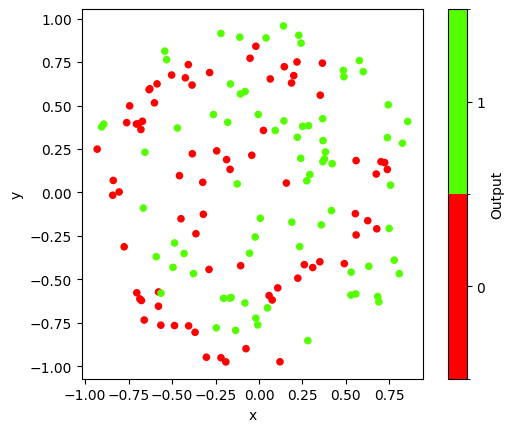

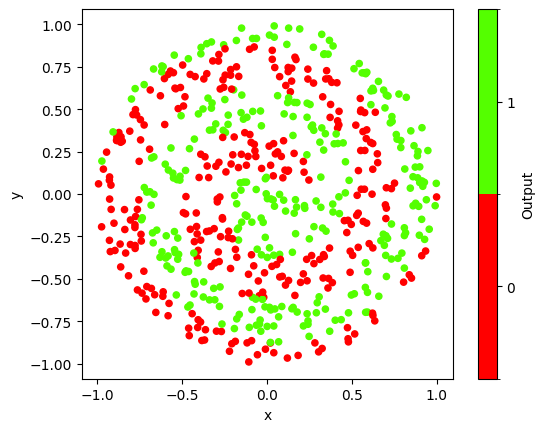

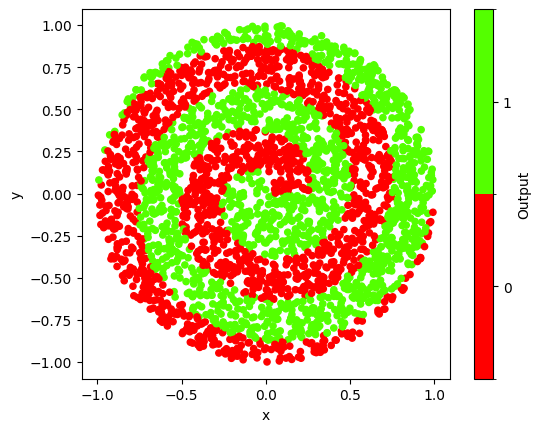

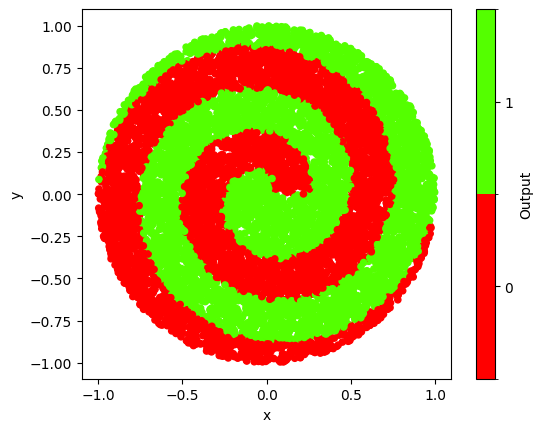

In [4]:
S1 = spirals(150)
S2 = spirals(600)
S3 = spirals(3000)
S_test = spirals(10000)

S1.plot.scatter(x="x", y="y", c="Output", cmap="prism").set_aspect('equal')
S2.plot.scatter(x="x", y="y", c="Output", cmap="prism").set_aspect('equal')
S3.plot.scatter(x="x", y="y", c="Output", cmap="prism").set_aspect('equal')
S_test.plot.scatter(x="x", y="y", c="Output", cmap="prism").set_aspect('equal')


 - Como podemos ver, el primer conjunto es evidentemente insuficiente para entender los datos. Incluso un ser humano sería incapaz de inferir del gráfico que las clases corresponden a espirales anidadas.

 - El segundo conjunto sigue sin ser demasiado claro, pero no resulta descabellado pensar que un árbol de decisión sería capaz de aprender el patrón.

 - Por su parte, el tercer conjunto exhibe claramente las dos espirales anidadas, con lo cual esperamos que el árbol aprenda a clasificar los puntos correctamente.

 - Lógicamente al tener más puntos aún, el conjunto de test también exhibe claramente los patrones. El propósito principal de graficar este último conjunto es ilustrar visualmente cómo se vería una predicción ideal de las clases sobre el conjunto de test. Luego contrastaremos esta imagen con las generadas a partir de la predicción de los distintos árboles.

Entrenaremos ahora a 3 árboles de decisión, cada uno creado a partir de su respectivo conjunto. Luego, usaremos cada árbol para predecir las clases de cada elemento del conjunto de test, y graficaremos los resultados para cada uno.

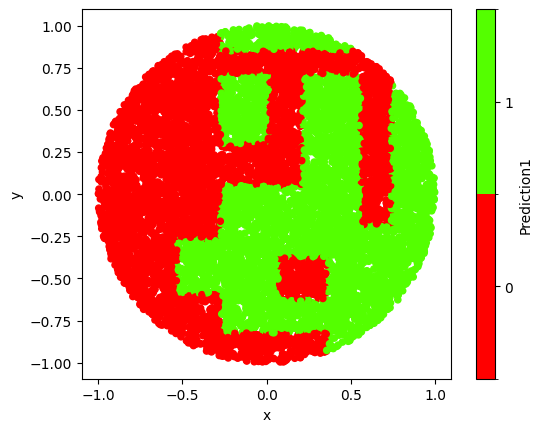

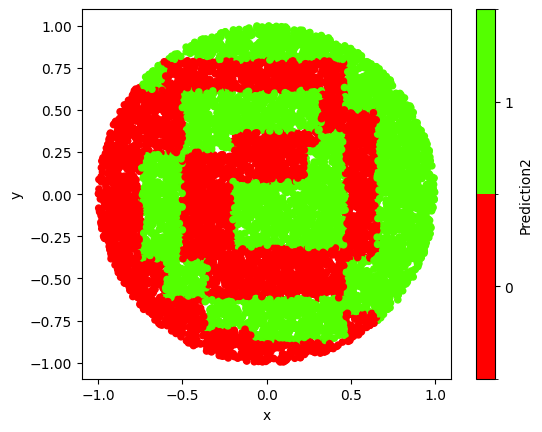

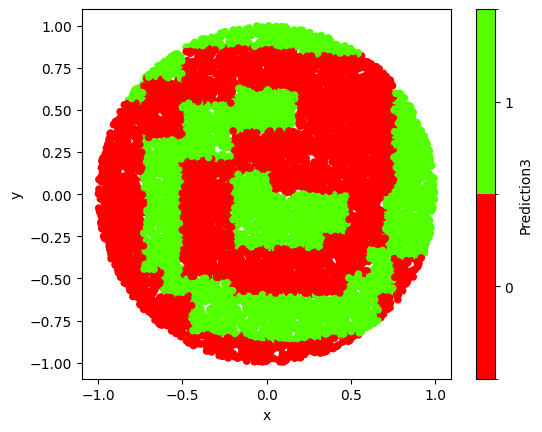

In [5]:
clf1 = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
clf1.fit(S1[["x", "y"]], S1["Output"])

clf2 = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
clf2.fit(S2[["x", "y"]], S2["Output"])

clf3 = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
clf3.fit(S3[["x", "y"]], S3["Output"])

S_test.insert(loc=3, column="Prediction1", value=clf1.predict(S_test[["x", "y"]]))
S_test.Prediction1 = S_test.Prediction1.astype('category')
S_test.insert(loc=4, column="Prediction2", value=clf2.predict(S_test[["x", "y"]]))
S_test.Prediction2 = S_test.Prediction2.astype('category')
S_test.insert(loc=5, column="Prediction3", value=clf3.predict(S_test[["x", "y"]]))
S_test.Prediction3 = S_test.Prediction3.astype('category')

S_test.plot.scatter(x="x", y="y", c="Prediction1", cmap="prism").set_aspect('equal')
S_test.plot.scatter(x="x", y="y", c="Prediction2", cmap="prism").set_aspect('equal')
S_test.plot.scatter(x="x", y="y", c="Prediction3", cmap="prism").set_aspect('equal')


De los gráficos producidos, destacamos las siguientes observaciones:

 - Tal como esperábamos, cada gráfico parece ser una mejor aproximación de la 'predicción ideal' que vimos anteriormente. Esto se debe a la cantidad y calidad de los distintos conjuntos de datos utilizados para entrenar a cada modelo.

 - Llaman la atención la cantidad de líneas rectas que se ven en los gráficos. Si lo pensamos bien, esto tiene sentido considerando la clase de decisiones que genera el árbol en su algoritmo de entrenamiento. Nuestros conjuntos de entrenamiento cuentan con dos atributos: $x$ e $y$. Ambos atributos son continuos, por lo que C4.5 no creará ramas del árbol para sus posibles valores, sino que generará predicados binarios del estilo $(x \leq 0.5)$ o $(y \geq 0.4)$. Visualmente, los puntos que cumplen o no con condiciones de este estilo están de uno u otro lado de una determinada recta, ya sea horizontal (para predicados sobre $y$) o vertical (para predicados sobre $x$). Entonces, cada camino en el árbol corresponde a una determinada partición del espacio 2D en el que toman valores nuestras variables. Es por esto que los gráficos resultantes siempre tienen como fronteras entre una clase y otra a líneas rectas alineadas con los ejes de coordenadas (conocidas justamente como "fronteras lineales").

 - De la observación anterior, podemos deducir que este problema puede resultarle particularmente complicado a un modelo que, esencialmente, sólo puede aprender a trazar líneas horizontales y verticales y asignarle a cada área resultante una clase. Esto se debe a que, para clasificar perfectamente una curva, necesitaríamos en realidad una cantidad infinita de dichas líneas. No obstante, la aproximación obtenida por nuestros modelos, particularmente el tercero, puede ser lo suficientemente precisa dependiendo del propósito para el que se utilice el árbol.

## Ejercicio 2
Nuevamente empezamos incluyendo el código para generar los datos, igual que lo hicimos en el TP anterior.

In [6]:
def diagonal(d, n, C):
  df = pd.DataFrame(np.random.normal(-1, C * np.sqrt(d), (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en -1 cada una
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(1, C * np.sqrt(d), (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en 1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

def paralelo(d, n, C):
  v0 = [-1] + [0] * (d - 1)
  v1 = [1] + [0] * (d - 1)
  df = pd.DataFrame(np.random.normal(v0, [C] * d, (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en la componente correspondiente de v0
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(v1, [C] * d, (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en v1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas


### Apartado A

Evaluaremos primero el aprendizaje de los datos correspondientes al generador `diagonal`. Generamos los 20 conjuntos de entrenamiento de cada tamaño. Entrenamos para cada uno un clasificador, y guardamos las estadísticas en un `DataFrame` de Pandas. Además, gráficamos las predicciones de un modelo de cada tamaño sobre el conjunto de test.

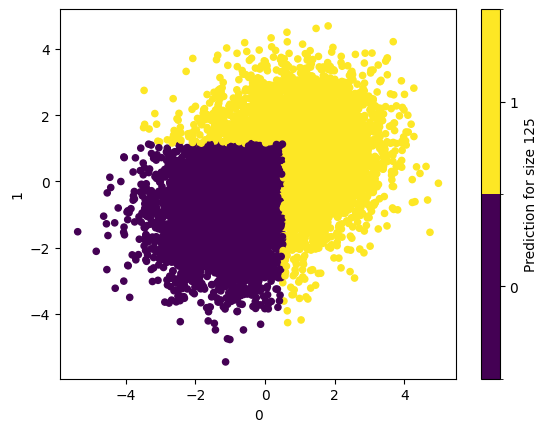

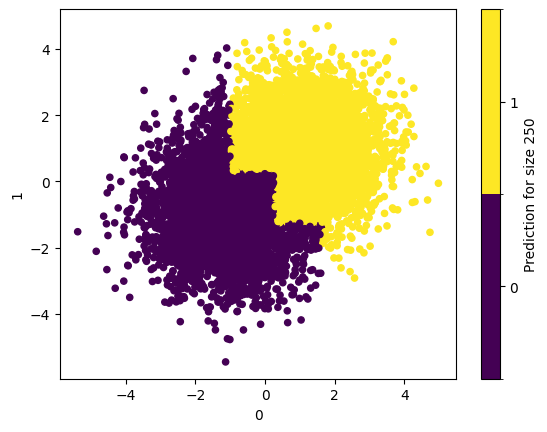

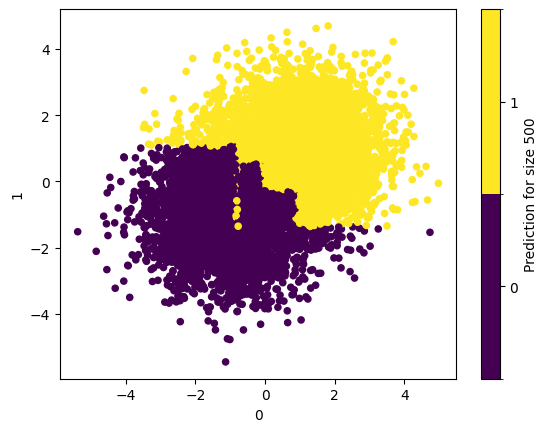

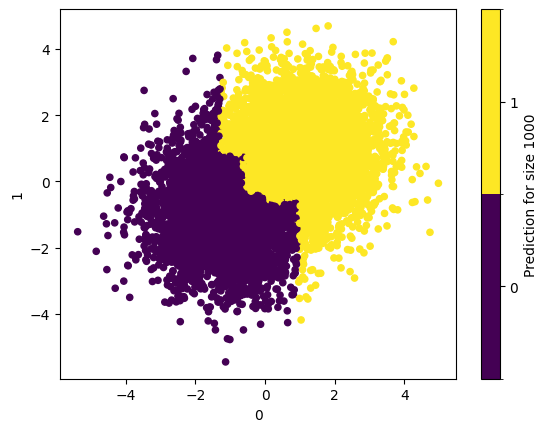

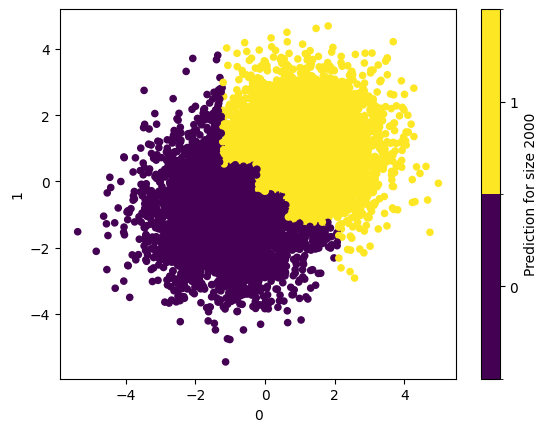

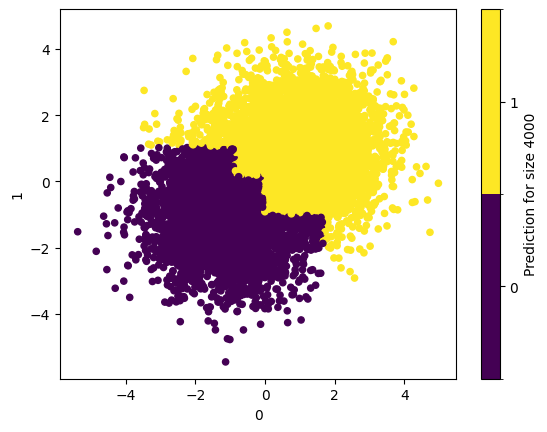

In [7]:
sizes = [125, 250, 500, 1000, 2000, 4000]
test_set = diagonal(2, 10000, 0.78)
diag_stats = []
for n in sizes:
  for k in range(20):
    training_set = diagonal(2, n, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[[0, 1]], training_set["Output"])
    diag_stats.append({"training set size": n, "node count": clf.tree_.node_count, "training set error": (1 - clf.score(training_set[[0, 1]], training_set["Output"])), "test set error": (1 - clf.score(test_set[[0, 1]], test_set["Output"]))})
    if (k == 0):
      test_set.insert(loc=len(test_set.columns) ,column=f"Prediction for size {n}", value=clf.predict(test_set[[0, 1]]))
      test_set[f"Prediction for size {n}"] = test_set[f"Prediction for size {n}"].astype('category')
      test_set.plot.scatter(x=0, y=1, c=f"Prediction for size {n}", cmap="viridis")
  
diag_stats = pd.DataFrame(diag_stats).groupby("training set size", as_index=False).mean()


Podemos ver que los gráficos generados por modelos entrenados sobre conjuntos más pequeños exhiben en su gráfica más artefactos visuales, que corresponden a decisiones aprendidas que no generalizan correctamente del conjunto de entrenamiento al conjunto de test.

Lo ideal para este problema sería que nuestro modelo aprenda a trazar una línea diagonal y clasifique en base al lado de la línea en el que se encuentra cada punto. Viendo la progresión de los gráficos, pareciera que los modelos se van acercando progresivamente a ese ideal.

Veremos ahora el error promedio sobre los conjuntos de training y test para los distintos tamaños de conjunto (promediado sobre los 20 modelos entrenados por cada tamaño).

<Axes: xlabel='training set size'>

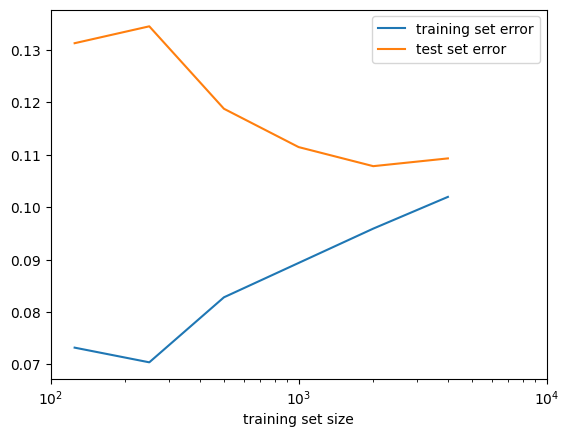

In [8]:
diag_stats.plot(x="training set size", y=["training set error", "test set error"], logx=True, xticks=[100, 1000, 10000])


Vemos que a medida que entrenamos sobre más datos, el error en el conjunto de test disminuye, incluso si su desempeño en el conjunto de entrenamiento empeora. Esto nos indica que en los modelos entrenados con menos datos se está produciendo un sobreajuste, que se corresponde con los artefactos visuales que veíamos en las gráficas. Esas clasificaciones, a simple vista erróneas, ajustaban mejor los datos de los conjuntos de entrenamiento más pequeños. A medida que aumentaba la cantidad de datos, el ruido de los mismos se reducía y hacía más difícil que el modelo sobreajuste.

Graficaremos también la cantidad de nodos de los árboles generados.

<Axes: xlabel='training set size'>

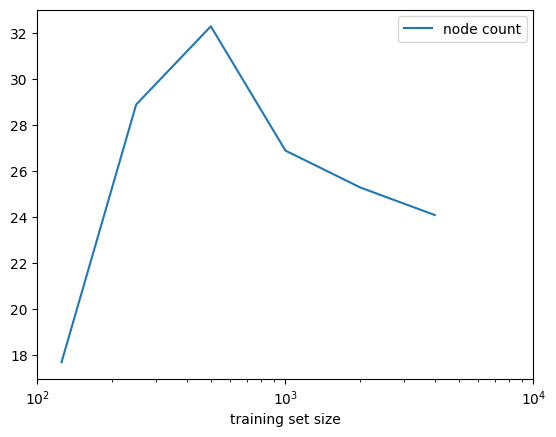

In [9]:
diag_stats.plot(x="training set size", y="node count", logx=True, xticks=[100, 1000, 10000])


Vemos que la cantidad de nodos, que se corresponde con la complejidad de las decisiones que toma nuestro modelo, aumenta hasta cierto punto, y luego desciende. Ese 'pico' que vemos en la cantidad de nodos también se corresponde con los artefactos visuales, que justamente corresponden a clasificaciones muy específicas que se ajustan bien al conjunto de entrenamiento pero no así al de test. Es por esto que a medida que la cantidad de datos aumenta, y el conjunto de entrenamiento se asemeja más en su distribución al de test, estas 'sobre-especificaciones' desaparecen en favor de un modelo más simple y que generaliza mejor.

### Apartado B
Ahora realizaremos estos mismos experimentos para el generador de datos `paralelo`. Al igual que antes, entrenamos los modelos y gráficamos un ejemplo de las predicciones para cada tamaño.

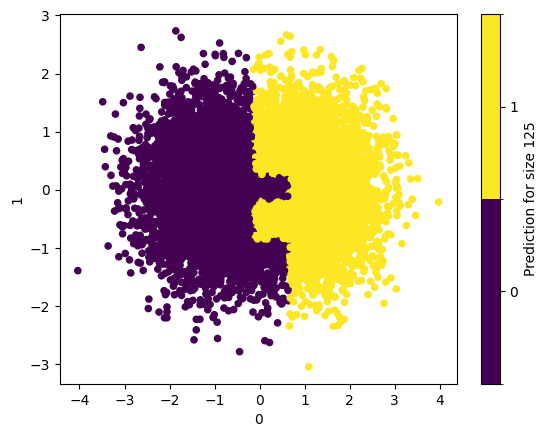

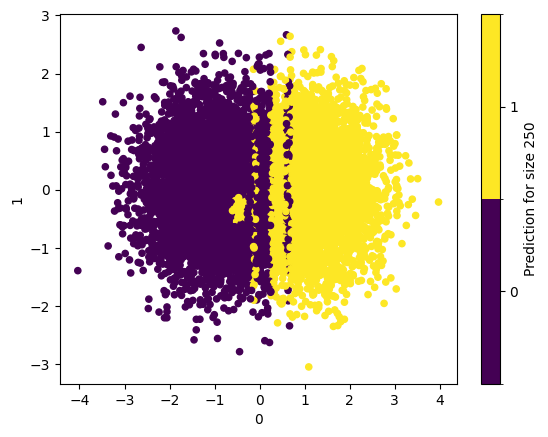

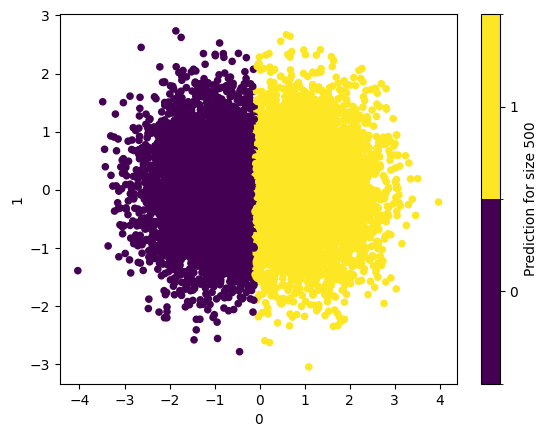

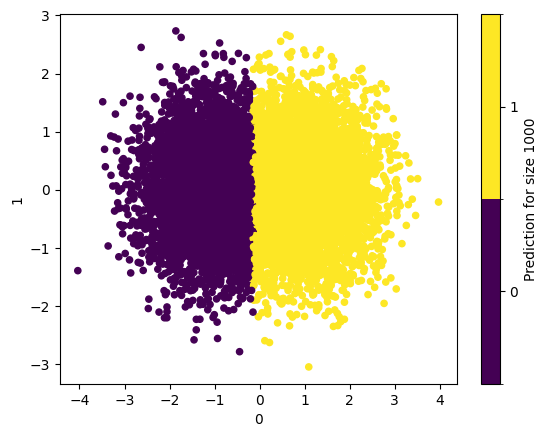

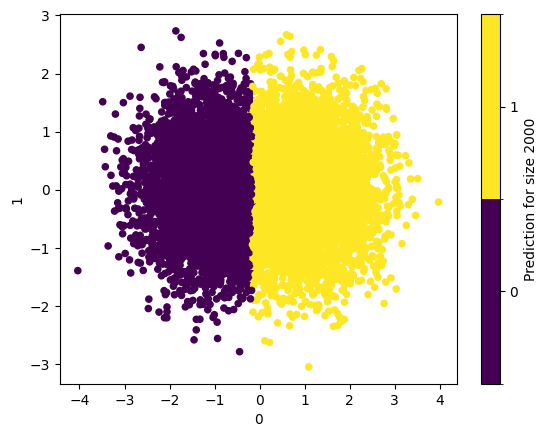

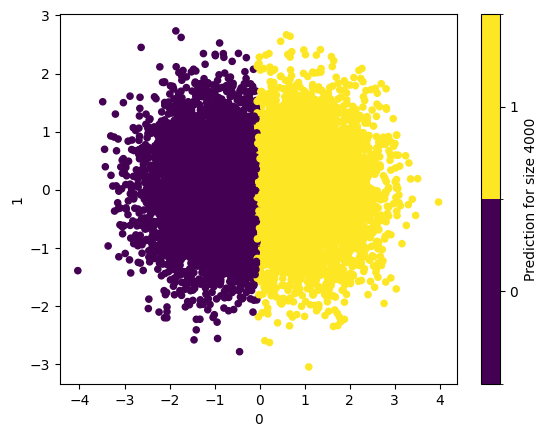

In [10]:
sizes = [125, 250, 500, 1000, 2000, 4000]
test_set = paralelo(2, 10000, 0.78)
parallel_stats = []
for n in sizes:
  for k in range(20):
    training_set = paralelo(2, n, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[[0, 1]], training_set["Output"])
    parallel_stats.append({"training set size": n, "node count": clf.tree_.node_count, "training set error": (1 - clf.score(training_set[[0, 1]], training_set["Output"])), "test set error": (1 - clf.score(test_set[[0, 1]], test_set["Output"]))})
    if (k == 0):
      test_set.insert(loc=len(test_set.columns) ,column=f"Prediction for size {n}", value=clf.predict(test_set[[0, 1]]))
      test_set[f"Prediction for size {n}"] = test_set[f"Prediction for size {n}"].astype('category')
      test_set.plot.scatter(x=0, y=1, c=f"Prediction for size {n}", cmap="viridis")
  
parallel_stats = pd.DataFrame(parallel_stats).groupby("training set size", as_index=False).mean()


Vemos que casi todas las gráficas son muy parecidas, excepto una (o dos o tres, según los datos que se generen). Parece ser que cuando los datos son pocos, pero no muy pocos, la clasificación aprendida es peor. En este problema, la clasificación ideal se basa en una simple línea dada por $x=0$. Con suficientes datos, el árbol aprende a hacer esta clasificación correctamente. Llamativamente, cuando los datos son muy escasos, también aprende a hacerla correctamente, posiblemente porque genera un árbol lo más simple posible, que para este problema en particular resulta ser lo ideal. Hay un punto en el medio, sin embargo, en el cual el modelo intenta ajustar por demás los datos, generando un árbol mucho más complejo que la simple línea vertical necesaria. Este también es un claro ejemplo de sobreajuste al conjunto de datos de entrenamiento.

Nuevamente, graficamos el error, y la cantidad de nodos de los árboles.

<Axes: xlabel='training set size'>

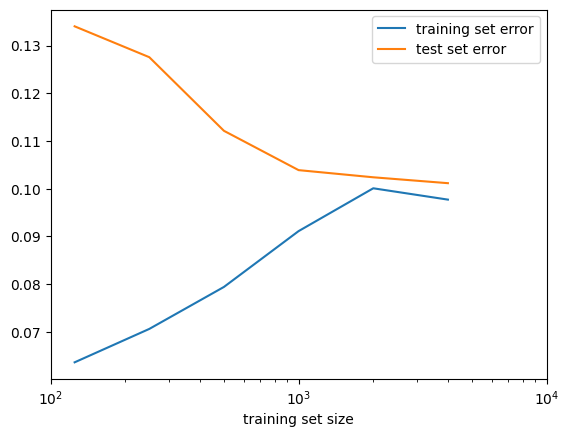

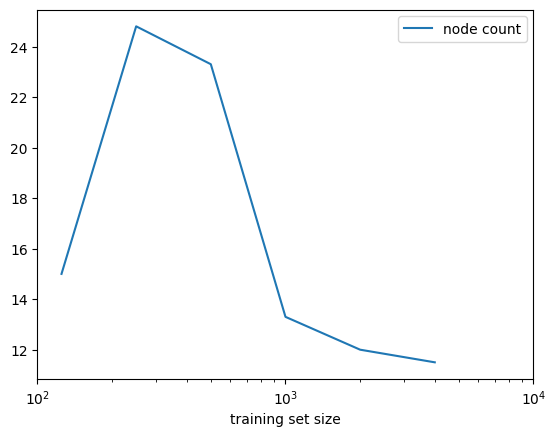

In [11]:
parallel_stats.plot(x="training set size", y=["training set error", "test set error"], logx=True, xticks=[100, 1000, 10000])
parallel_stats.plot(x="training set size", y="node count", logx=True, xticks=[100, 1000, 10000])

Vemos tendencias que en líneas generales son muy similares a las vistas en el problema anterior. Podríamos concluir que modelos entrenados en datos que no son lo suficientemente representativos de la distribución subyacente de los datos reales tienden al sobreajuste. Sin embargo, como los modelos entrenados con pocos datos generan árboles con menor cantidad de nodos, para problemas simples como los dos que probamos es posible que se creen clasificadores que funcionan mejor que otros con una cantidad de datos un poco mayor, ya que estos aprenden patrones más complejos que pueden no aplicar al dominio del problema. De todas formas, eventualmente se llega un punto en el que la cantidad de datos es lo suficientemente representativa como para aprender sin problemas la clasificación correcta, y esto siempre va a ser preferible de ser posible.

### Apartado c
Por último, superpondremos las gráficas de los dos problemas para poder comparar el desempeño de los modelos en cada uno.

<Axes: xlabel='training set size'>

<Axes: xlabel='training set size'>

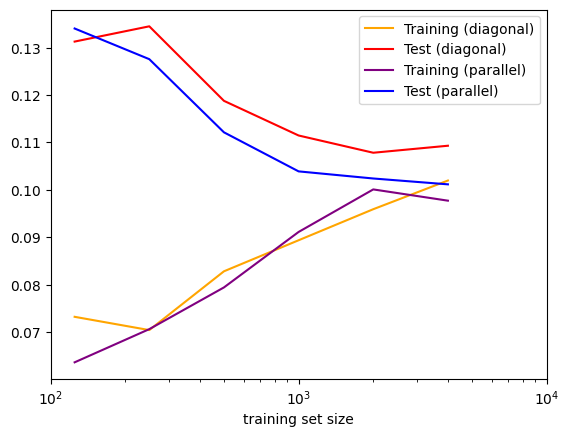

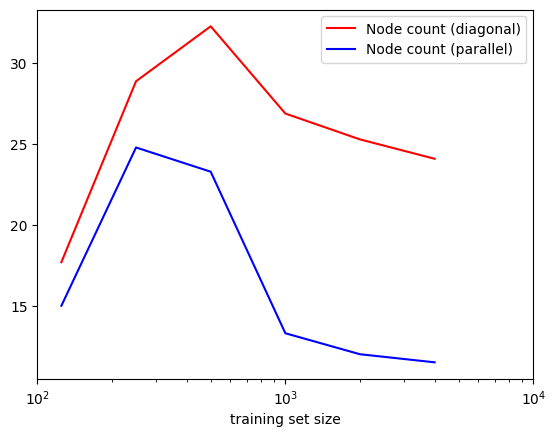

In [12]:
diag_ax = diag_stats.plot.line(x="training set size", y=["training set error", "test set error"], color=["orange", "red"], logx=True, xticks=[100, 1000, 10000])
parallel_stats.plot.line(ax=diag_ax, x="training set size", y=["training set error", "test set error"], color=["purple", "blue"], logx=True, xticks=[100, 1000, 10000])
diag_ax.legend(labels=["Training (diagonal)", "Test (diagonal)", "Training (parallel)", "Test (parallel)"])
display(diag_ax)

diag_ax = diag_stats.plot.line(x="training set size", y="node count", color="red", logx=True, xticks=[100, 1000, 10000])
parallel_stats.plot.line(ax=diag_ax, x="training set size", y="node count", color="blue", logx=True, xticks=[100, 1000, 10000])
diag_ax.legend(labels=["Node count (diagonal)", "Node count (parallel)"])
display(diag_ax)

Podemos ver que el problema de clasificar los datos generados por `paralelo` parece ser una tarea más simple que la de clasificar datos de `diagonal`. Para `paralelo` se crean modelos con menor cantidad de nodos, y que aún así obtienen un error menor. Esto concuerda con lo dicho anteriormente, que los árboles de decisión describen más fácilmente problemas cuyas fronteras entre clases son rectas alineadas a los ejes de coordenadas.

## Ejercicio 3
En este ejercicio compararemos el desempeño de los clasificadores en los dos problemas ya vistos, variando el overlapping entre clases. El código a continuación se encarga de entrenar a los modelos en distintos sets de entrenamiento generados con overlapping distinto, promediar su desempeño, y graficar los resultados obtenidos. En el gráfico tambien se incluirán líneas correspondientes a los errores mínimos que se podían obtener para cada conjunto de datos de test. Para hacer esto, nos basamos en el error que obtendría el clasificador ideal de cada problema.

En estos problemas particulares, resulta simple encontrar cuál es el clasificador ideal.

En el generador `paralelo`, los puntos son generados por $d$ variables aleatorias independientes, todas con la misma desviación estándar, pero con diferente centro. Todas las componentes menos la primera tienen centro en $0$, independientemente de la clase a la que pertenezca. Por lo tanto, la única componente que nos puede proveer información es la primera, que tiene centro en $-1$ o $1$ según la clase. Con lo cual, el clasificador ideal debería sólo fijarse en si la primer componente está más cerca de $-1$ o de $1$, y decidir en base a eso. Para un punto $x$ esto se traduce simplemente al predicado $x_0 > 0$.

El generador `diagonal` es ligeramente más complicado, más que nada en dimensiones superiores (como en este caso, que usamos $d=5$). Cada clase genera puntos centrados en $(-1, -1, \dots, -1)$ y $(1, 1, \dots, 1)$ respectivamente. Nuevamente, un clasificador ideal simplemente debe fijarse en si un determinado punto está más cerca de $(-1, -1, \dots, -1)$ o $(1, 1, \dots, 1)$. Sin embargo, a diferencia de `paralelo`, aquí debemos valernos de todas las variables para determinar esto. Podemos pensar que el espacio $d$-dimensional se divide en 2: Los puntos más cercanos a $(-1, -1, \dots, -1)$ y los puntos más cercanos a $(1, 1, \dots, 1)$. La frontera entre estas particiones es un hiperplano centrado en el origen, con vector normal $(1, 1, \dots, 1)$. La ecuación de este plano, entonces, es:

$$x_0 + x_1 + \dots + x_d = 0$$

Y para determinar de qué lado del plano está un determinado punto, basta con calcular si $x_0 + x_1 + \dots + x_d$ es mayor o menor a 0, respectivamente.

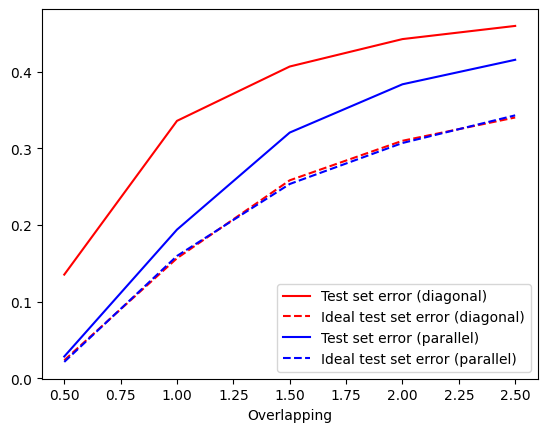

In [13]:
C_values = np.linspace(0.5, 2.5, 5)
diag_stats = []
diag_ideal_stats = []

def diag_ideal(x):
  return int(x.Output == (int(x[0] + x[1] + x[2] + x[3] + x[4] > 0)))

for C in C_values:
  test_set = diagonal(5, 10000, C)
  diag_ideal_stats.append(1 - test_set.apply(axis='columns', func=diag_ideal).sum() / 10000)
  for k in range(20):
    training_set = diagonal(5, 250, C)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[[0, 1]], training_set["Output"])
    diag_stats.append({"Overlapping": C, "test set error": (1 - clf.score(test_set[[0, 1]], test_set["Output"]))})
  
diag_stats = pd.DataFrame(diag_stats).groupby("Overlapping", as_index=False).mean()
diag_stats.insert(loc=len(diag_stats.columns), column="ideal error", value=diag_ideal_stats)

parallel_stats = []
parallel_ideal_stats = []

def parallel_ideal(x):
  return int(x.Output == (int(x[0] > 0)))

for C in C_values:
  test_set = paralelo(5, 10000, C)
  parallel_ideal_stats.append(1 - test_set.apply(axis='columns', func=parallel_ideal).sum() / 10000)
  for k in range(20):
    training_set = paralelo(5, 250, C)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[[0, 1]], training_set["Output"])
    parallel_stats.append({"Overlapping": C, "test set error": (1 - clf.score(test_set[[0, 1]], test_set["Output"]))})
  
parallel_stats = pd.DataFrame(parallel_stats).groupby("Overlapping", as_index=False).mean()
parallel_stats.insert(loc=len(parallel_stats.columns), column="ideal error", value=parallel_ideal_stats)

diag_ax = diag_stats.plot.line(x="Overlapping", y=["test set error", "ideal error"], style=["-", "--"], color="red")
parallel_stats.plot.line(ax=diag_ax, x="Overlapping", y=["test set error", "ideal error"], style=["-", "--"], color="blue")
diag_ax.legend(labels=["Test set error (diagonal)", "Ideal test set error (diagonal)", "Test set error (parallel)", "Ideal test set error (parallel)"])

Vemos que, lógicamente, el error aumenta a medida que el overlapping de las clases aumenta. No sólo eso, sino que tambien a medida que aumenta el overlapping, el error producido por nuestros modelos se aleja más del menor error posible, producido por el clasificador ideal.

Otra observación notable es que nuestro modelo suele tener un mayor error en el problema `diagonal` que en el problema `paralelo`. Sin embargo, el menor error posible en `diagonal` es siempre menor que el menor error posible para el problema `paralelo` con el mismo overlapping. Esto quiere decir que, si bien existen mejores soluciones que podríamos encontrar para `diagonal` que para `paralelo`, nuestro modelo aprende con mayor facilidad soluciones de `paralelo` que de `diagonal`. Esto puede explicarse con las fronteras lineales que vimos anteriormente. Como la clasificación ideal a aprender en `paralelo` está basada en 'líneas' paralelas a los ejes de coordenadas, esos patrones se aprender con mayor facilidad.

De la observación anterior quizás tambien querramos preguntarnos por qué es menor el error ideal en `diagonal` que en `paralelo`. Una explicación posible es que en `diagonal` todas las variables nos pueden aportar información, ya que todas tienen una distribución distinta dependiendo de la clase a la que pertenecen. En `paralelo`, en cambio, sólo la primer componente tiene una distribución diferente para cada clase. Es posible que aumentando la dimensionalidad de los datos, el error ideal en `diagonal` amplíe aún más su diferencia con el error ideal en `paralelo`.

## Ejercicio 4
Análogamente a los dos ejercicios anteriores, crearemos para cada problema distintos clasificadores entrenados en datos donde variamos uno de los parámetros de los generadores. En este ejercicio, variaremos la dimensionalidad de los datos. Luego, graficamos el error para los dos problemas, tanto en el conjunto de entrenamiento como en el de test.

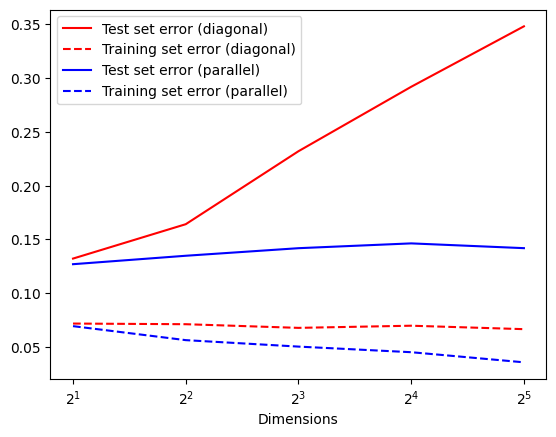

In [14]:
d_values = [2,4,8,16,32]

diag_stats = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(20):
    training_set = diagonal(d, 250, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[list(range(0, d))], training_set["Output"])
    diag_stats.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

parallel_stats = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(20):
    training_set = paralelo(d, 250, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[list(range(0, d))], training_set["Output"])
    parallel_stats.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

diag_stats = pd.DataFrame(diag_stats).groupby("Dimensions", as_index=False).mean()

parallel_stats = pd.DataFrame(parallel_stats).groupby("Dimensions", as_index=False).mean()

diag_ax = diag_stats.plot.line(x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="red", logx=True) 
parallel_stats.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="blue", logx=True)
diag_ax.legend(labels=["Test set error (diagonal)", "Training set error (diagonal)", "Test set error (parallel)", "Training set error (parallel)"])
diag_ax.set_xscale("log", base=2)

Podemos ver que el error en el conjunto de test aumenta de manera logarítmica (que se ve como una línea más o menos recta en nuestro gráfico) en el problema `diagonal`, pero casi no aumenta en el problema `paralelo`. Por su parte, en el conjunto de training es `paralelo` quien exhibe un descenso en línea recta (correspondiente a un descenso real logarítmico), mientras que `diagonal` mantiene su error estable.

Mirando en conjunto el error en training y en test para cada problema, podemos ver que la distancia entre los errores en `diagonal` se va ampliando, mientras que la de `paralelo`, si bien tambien se amplia, lo hace en mucha menor medida, y debido a una disminución en el error de training, en lugar de por un aumento del error en test. El hecho de que la diferencia en `diagonal` se amplíe por un aumento del error en test, mientras que se mantiene estable el error en training, nos indica que lo que está aumentando es el sobreajuste. Una hipótesis posible de por qué este es el caso, es que a medida que aumentan las dimensiones, a nuestro árbol le resulta más dificil imitar la partición del espacio que induce el hiperplano que supone el clasificador ideal, ya que como dijimos, se límita a fronteras paralelas a los ejes de coordenadas, mientras que nuestro hiperplano no es paralelo a ninguno de ellos (recordemos que su vector normal es $(1, 1, \dots, 1)$). Por otro lado, en `paralelo`, el hiperplano del clasificador ideal sí está alineado con el eje de coordenadas, por lo que nuestros clasificadores no parecen presentar mayores problemas para aproximarlo.

## Ejercicio 5
Cargamos el problema XOR del CSV provisto, y graficamos sus clases.

<Axes: xlabel='x', ylabel='y'>

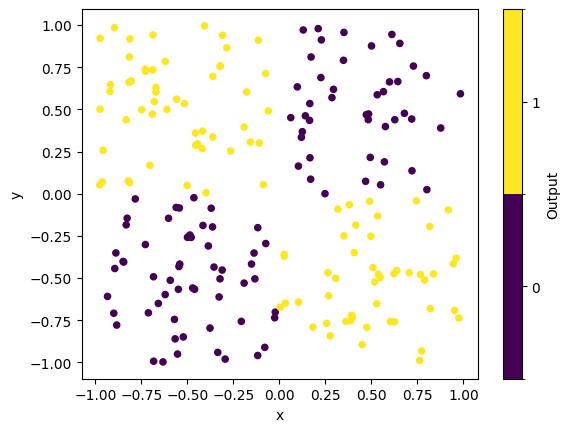

In [15]:
data = pd.read_csv("xor.csv", names=["x", "y", "Output"])
data.Output = data.Output.astype("category")
data.plot.scatter(x="x", y="y", c="Output", cmap="viridis")

Vemos que cada punto $(x, y)$ pertenece a la clase 0 o 1 según si el predicado $x y \geq 0$ es verdadero o falso respectivamente. Un árbol que clasificaría a este problema idealmente se vería como el siguiente diagrama:

```mermaid
  graph TD;
      A["x ≥ 0"]-->|True|B["y ≥ 0"];
      A-->|False|C["y ≥ 0"];
      B-->|True|D(("0"));
      B-->|False|E(("1"));
      C-->|True|F(("1"));
      C-->|False|G(("0"));
```

<sup>(Para ver el diagrama en VSCode, se necesita la extensión [Markdown Preview Mermaid Support](https://marketplace.visualstudio.com/items?itemName=bierner.markdown-mermaid))</sup>

Este árbol esencialmente es un XOR sobre los predicados $x \geq 0$ y $y \geq 0$, de ahí el nombre del problema.

Ahora entrenaremos un clasificador con los datos provistos y veremos sus predicciones sobre el conjunto.

In [16]:
clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.03,random_state=0,min_samples_leaf=5)
clf.fit(data[["x", "y"]], data.Output)
clf.predict(data[["x", "y"]])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

Sorprendentemente, el clasificador está prediciendo la clase 0 para todos los ejemplos! De todas formas, esto tiene una explicación simple.

A nuestro clasificador le estamos pasando el parámetro `min_impurity_decrease=0.03`. Esto le dice que sólo debe partir un nodo si consigue una ganancia de información mayor a cierto número mínimo (en este caso 0.03). Si lo pensamos, al principio ninguna decisión posible sobre $x$ o $y$ nos dará información. Si usaramos, por ejemplo, el predicado $x \geq 0$, pasaríamos a tener dos nuevos conjuntos de datos, donde cada uno está dividido 50-50 entre las clases. Esto quiere decir que nuestra ganancia de información es nula. Lo mismo pasaría si eligiéramos el predicado $y \geq 0$, o algún otro predicado. El problema es que una decisión basada en una única variable no nos da ninguna ganancia de información, en este problema en particular. Si hiciéramos cualquier decisión arbitrariamente en este primer paso, luego podríamos construir exitosamente un árbol de decisión, pero como estamos obligando a nuestro árbol a sólo crear ramas cuando haya una ganancia positiva de información, nos quedamos en un árbol que no es tan bueno como podría serlo.